In [16]:
%matplotlib inline
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial, name)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,2,2,1],padding="SAME")

def deconv2d(x,W,output_shape):
    return tf.nn.conv2d_transpose(x,W,output_shape,strides=[1,2,2,1],padding="SAME")

tf.reset_default_graph()
x=tf.placeholder(tf.float32,shape=[None,784])
x_origin=tf.reshape(x,[-1,28,28,1])

W_e_conv1=weight_variable([5,5,1,16],"w_e_conv1")
b_e_conv1=bias_variable([16],"b_e_conv1")
h_e_conv1=tf.nn.relu(tf.add(conv2d(x_origin,W_e_conv1),b_e_conv1))

W_e_conv2=weight_variable([5,5,16,32],"w_e_conv2")
b_e_conv2=bias_variable([32],"b_e_conv2")
h_e_conv2=tf.nn.relu(tf.add(conv2d(h_e_conv1,W_e_conv2),b_e_conv2))

code_layer=h_e_conv2
print("code layer shape : %s" % h_e_conv2.get_shape())

W_d_conv1=weight_variable([5,5,16,32],"w_d_conv1")
b_d_conv1=bias_variable([1],"b_d_conv1")
output_shape_d_conv1=tf.stack([tf.shape(x)[0],14,14,16])
h_d_conv1=tf.nn.relu(deconv2d(h_e_conv2,W_d_conv1,output_shape_d_conv1))

W_d_conv2=weight_variable([5,5,1,16],"w_d_conv2")
b_d_conv2=bias_variable([16],"b_d_conv2")
output_shape_d_conv2=tf.stack([tf.shape(x)[0],28,28,1])
h_d_conv2=tf.nn.relu(deconv2d(h_d_conv1,W_d_conv2,output_shape_d_conv2))



x_reconstruct=h_d_conv2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())



code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, ?, ?, ?)


In [7]:
cost=tf.reduce_mean(tf.pow(x_reconstruct-x_origin,2))
optimizer=tf.train.AdamOptimizer(0.01).minimize(cost)

sess=tf.InteractiveSession()
batch_size=60
init_op=tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch=mnist.train.next_batch(batch_size)
    if epoch<1500:
        if epoch%100==0:
            print("step %d,loss %g" % (epoch,cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000==0:
            print("step %d,loss %g" % (epoch,cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x:batch[0]})

step 0,loss 0.107011
step 100,loss 0.0108166
step 200,loss 0.00464175
step 300,loss 0.00348879
step 400,loss 0.00285434
step 500,loss 0.00279001
step 600,loss 0.00217519
step 700,loss 0.00200764
step 800,loss 0.00167769
step 900,loss 0.00154061
step 1000,loss 0.00251237
step 1100,loss 0.00144653
step 1200,loss 0.00134208
step 1300,loss 0.00115027
step 1400,loss 0.00133523
step 2000,loss 0.000915447
step 3000,loss 0.000656867
step 4000,loss 0.0005741


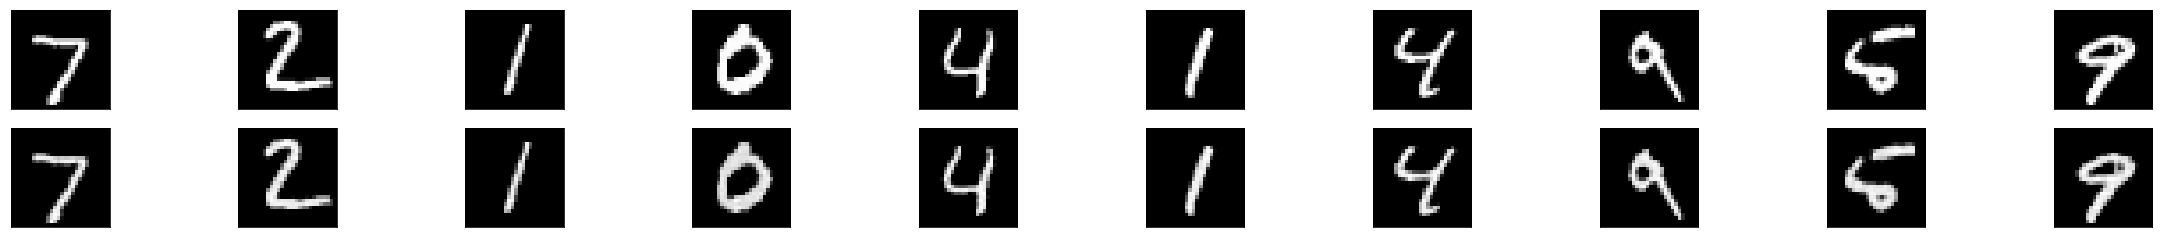

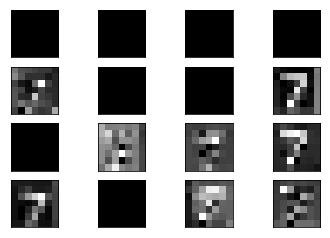

In [8]:
def plot_n_reconstruct(origin_img,reconstruct_img,n=10):
    plt.figure(figsize=(2*20,4))
    
    for i in range(n):
        ax=plt.subplot(2,n,i+1)
        plt.imshow(origin_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax=plt.subplot(2,n,i+1+n)
        plt.imshow(reconstruct_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

test_size=10
test_origin_img=mnist.test.images[0:test_size,:]
test_reconstruct_img=np.reshape(x_reconstruct.eval(feed_dict={x:test_origin_img}),[-1,28,28,1])
plot_n_reconstruct(test_origin_img,test_reconstruct_img)


#plot code layer result
import math
def plot_conv_layer(layer,image,num_filters):
    output=sess.run(layer,feed_dict={x:[image]})
    
    num_grids=int(math.ceil(math.sqrt(num_filters)))
    
    fig,axes=plt.subplots(num_grids,num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i< num_grids*num_grids:
            img=output[0,:,:,i]
            ax.imshow(img,interpolation='nearest',cmap='gray')
            
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

image1=mnist.test.images[0]
plot_conv_layer(code_layer,image1,16)

In [17]:
################   Max unpooling

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")
def deconv2d(x,W,output_shape):
    return tf.nn.conv2d_transpose(x,W,output_shape,strides=[1,1,1,1],padding="SAME")
def max_unpool_2x2(x,output_shape):
    out=tf.concat([x,tf.zeros_like(x)],3)
    out=tf.concat([out,tf.zeros_like(out)],2)
    out_size=output_shape
    return tf.reshape(out,out_size)
def max_pool_2x2(x):
    _,argmax=tf.nn.max_pool_with_argmax(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    pool=tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    return pool,argmax


tf.reset_default_graph()
x=tf.placeholder(tf.float32,shape=[None,784])
x_origin=tf.reshape(x,[-1,28,28,1])

W_e_conv1=weight_variable([5,5,1,16],"w_e_conv1")
b_e_conv1=bias_variable([16],"b_e_conv1")
h_e_conv1=tf.nn.relu(tf.add(conv2d(x_origin,W_e_conv1),b_e_conv1))
h_e_pool1,argmax_e_pool1=max_pool_2x2(h_e_conv1)

W_e_conv2=weight_variable([5,5,16,32],"w_e_conv2")
b_e_conv2=bias_variable([32],"b_e_conv2")
h_e_conv2=tf.nn.relu(tf.add(conv2d(h_e_pool1,W_e_conv2),b_e_conv2))
h_e_pool2,argmax_e_pool2=max_pool_2x2(h_e_conv2)



code_layer=h_e_pool2
print("code layer shape : %s" % code_layer.get_shape())

W_d_conv1=weight_variable([5,5,16,32],"w_d_conv1")
b_d_conv1=bias_variable([1],"b_d_conv1")

#convolutional layer 不改變輸出的shape
output_shape_d_conv1=tf.stack([tf.shape(x)[0],7,7,16])
h_d_conv1=tf.nn.sigmoid(deconv2d(code_layer,W_d_conv1,output_shape_d_conv1))

#max unpool layer 改變輸出的shape為兩倍
output_shape_d_pool1=tf.stack([tf.shape(x)[0],14,14,16])
h_d_pool1=max_unpool_2x2(h_d_conv1,output_shape_d_pool1)

W_d_conv2=weight_variable([5,5,1,16],"w_d_conv2")
b_d_conv2=bias_variable([16],"b_d_conv2")

output_shape_d_conv2=tf.stack([tf.shape(x)[0],14,14,1])
h_d_conv2=tf.nn.sigmoid(deconv2d(h_d_pool1,W_d_conv2,output_shape_d_conv2))

output_shape_d_pool2=tf.stack([tf.shape(x)[0],28,28,1])
h_d_pool2=max_unpool_2x2(h_d_conv2,output_shape_d_pool2)

x_reconstruct=h_d_pool2
print('reconstruct layer shape : %s' % x_reconstruct.get_shape())

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, 28, 28, 1)


In [18]:
cost=tf.reduce_mean(tf.pow(x_reconstruct-x_origin,2))
optimizer=tf.train.AdamOptimizer(0.01).minimize(cost)

sess=tf.InteractiveSession()
batch_size=60
init_op=tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch=mnist.train.next_batch(batch_size)
    if epoch <1500:
        if epoch%100==0:
            print("step %d, loss %g" % (epoch,cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000==0:
            print("step %d, loss %g" % (epoch,cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x:batch[0]})

print("final loss %g" % cost.eval(feed_dict={x:mnist.test.images}))

step 0, loss 0.153439
step 100, loss 0.105016
step 200, loss 0.0944555
step 300, loss 0.0936267
step 400, loss 0.0877271
step 500, loss 0.0862367
step 600, loss 0.0851463
step 700, loss 0.0863439
step 800, loss 0.0859425
step 900, loss 0.0894035
step 1000, loss 0.0847582
step 1100, loss 0.083606
step 1200, loss 0.0864502
step 1300, loss 0.086598
step 1400, loss 0.0873422
step 2000, loss 0.0815363
step 3000, loss 0.0873997
step 4000, loss 0.0842864
final loss 0.0859975


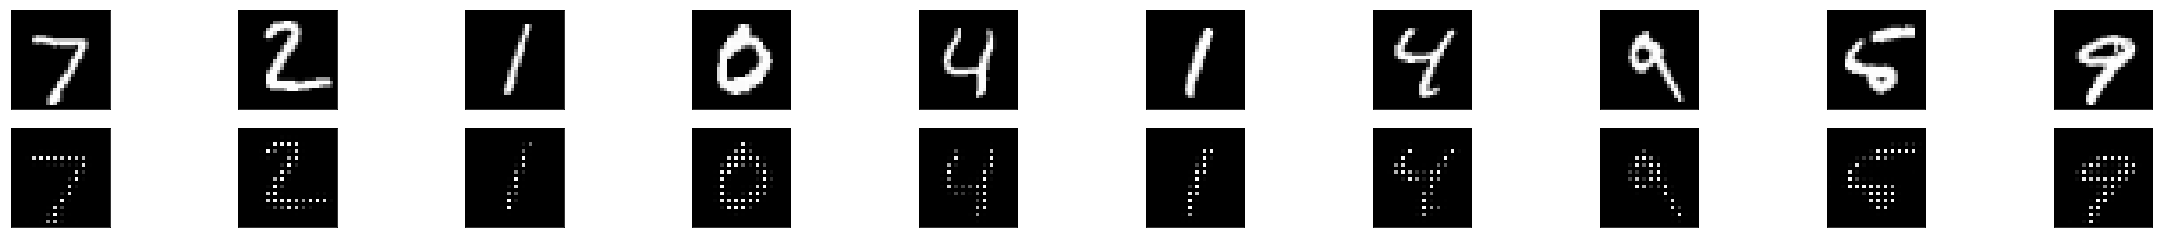

In [19]:
test_size=10
test_origin_img=mnist.test.images[0:test_size,:]
test_reconstruct_img=np.reshape(x_reconstruct.eval(feed_dict={x:test_origin_img}),
                               [-1,28*28])
plot_n_reconstruct(test_origin_img,test_reconstruct_img)

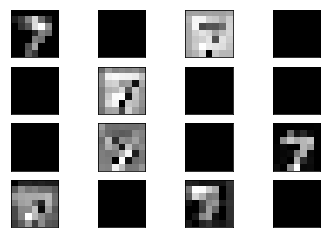

In [20]:
#code layer
image1=mnist.test.images[0]
plot_conv_layer(code_layer,image1,16)

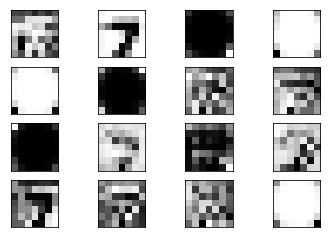

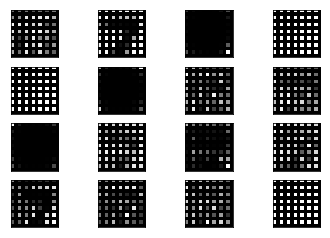

In [21]:
#deconvolution 1
plot_conv_layer(h_d_conv1,image1,16)

#unpooling 1
plot_conv_layer(h_d_pool1,image1,16)

In [23]:
################   Max unpooling---nearest_neighbor
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return pool, argmax

def max_unpool_2x2(x, shape):
    inference = tf.image.resize_nearest_neighbor(x, tf.stack([shape[1]*2, shape[2]*2]))
    return inference

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1, 28, 28, 1])

W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))
h_e_pool1, argmax_e_pool1 = max_pool_2x2(h_e_conv1)

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_pool1, W_e_conv2), b_e_conv2))
h_e_pool2, argmax_e_pool2 = max_pool_2x2(h_e_conv2)

code_layer = h_e_pool2
print("code layer shape : %s" % code_layer.get_shape())

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1")

# convolutional layer 不改變輸出的 shape
output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 7, 7, 16])
h_d_conv1 = tf.nn.sigmoid(deconv2d(code_layer, W_d_conv1, output_shape_d_conv1))

# max unpool layer 改變輸出的 shape 為兩倍
h_d_pool1 = max_unpool_2x2(h_d_conv1, [-1, 7, 7, 16])

W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")

# convolutional layer 不改變輸出的 shape
output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 14, 14, 1])
h_d_conv2 = tf.nn.sigmoid(deconv2d(h_d_pool1, W_d_conv2, output_shape_d_conv2))

# max unpool layer 改變輸出的 shape 為兩倍
h_d_pool2 = max_unpool_2x2(h_d_conv2, [-1, 14, 14, 1])

x_reconstruct = h_d_pool2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())

cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

sess = tf.InteractiveSession()
batch_size = 60
init_op = tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch = mnist.train.next_batch(batch_size)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images}))

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, 28, 28, ?)
step 0, loss 0.58477
step 100, loss 0.087572
step 200, loss 0.0454569
step 300, loss 0.0357156
step 400, loss 0.0258678
step 500, loss 0.0241883
step 600, loss 0.0223742
step 700, loss 0.0202364
step 800, loss 0.0191041
step 900, loss 0.0175203
step 1000, loss 0.0190635
step 1100, loss 0.0185155
step 1200, loss 0.0178987
step 1300, loss 0.0176776
step 1400, loss 0.0181427
step 2000, loss 0.0180501
step 3000, loss 0.0179247
step 4000, loss 0.0180038
final loss 0.0174723


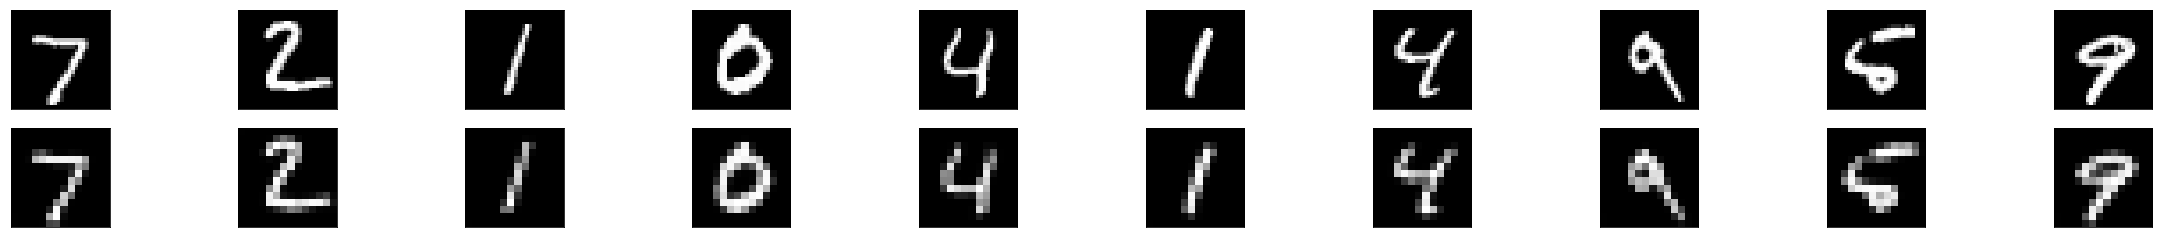

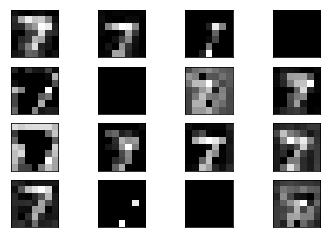

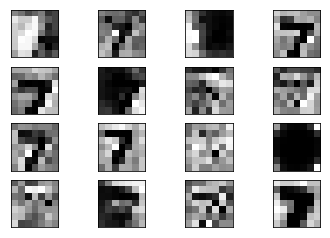

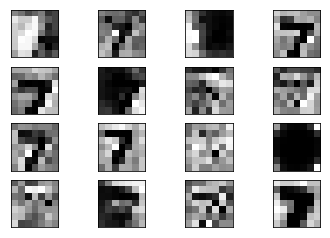

In [24]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

#code layer
image1 = mnist.test.images[0]
plot_conv_layer(code_layer, image1, 16)

#unconvolutional layer
image1 = mnist.test.images[0]
plot_conv_layer(h_d_conv1, image1, 16)

#unpooling layer
image1 = mnist.test.images[0]
plot_conv_layer(h_d_pool1, image1, 16)